In [2]:
import galsim
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt


In [15]:
#Set parameters
gsparams = galsim.GSParams(kvalue_accuracy=1.e-5,maximum_fft_size=2048*10,maxk_threshold=1.e-5)

pixel_scale = 0.1 #as/px
lamda = 550 #nm
diameter = 1.2 #m
psf_oversample = 5.
gal_oversample = 2.
# Make epsf, draw epsf image, interpolated image
airy = galsim.Airy(lam=lamda, diam=diameter, scale_unit=galsim.arcsec, obscuration=0.3, gsparams=gsparams)
pixel = galsim.Pixel(pixel_scale,gsparams=gsparams)
psf = galsim.Convolve(airy, pixel)
given_psf = psf.drawImage(scale=pixel_scale/psf_oversample,method='no_pixel') #Draw oversampled psf image
psf_galsample = psf.drawImage(scale=pixel_scale/gal_oversample,method='no_pixel') #Draw at galaxy scale for shape measurement
psfii = galsim.InterpolatedImage(given_psf, gsparams=gsparams)

In [16]:
#Load galaxy catalog and select galaxies
cc = galsim.COSMOSCatalog(dir='/disks/shear15/KiDS/ImSim/pipeline/data/COSMOS_25.2_training_sample/',use_real=False)
sersicfit = cc.param_cat['sersicfit']
hlr, sn, q, phi = [sersicfit[:,i] for i in (1,2,3,7)]

small100I = np.where(np.logical_and(hlr*np.sqrt(q)>2.5, sn>=0.5))[0][0] #Large galaxies, reasonable sersic n
gals = cc.makeGalaxy(small100I, chromatic=False, gsparams=gsparams)

In [17]:
#gals = galsim.Gaussian(sigma=.1)

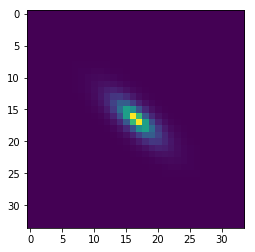

In [18]:
galim = gals.drawImage(scale=pixel_scale/2.)
plt.imshow(galim.array)

In [19]:
ss = pixel_scale / gal_oversample
nx = 5
inc = ss / nx / 2
print inc

0.005


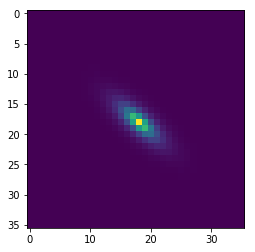

In [20]:
galshift = gals.shift((inc*nx,inc*nx))
galim = galshift.drawImage(scale=pixel_scale/2.)
plt.imshow(galim.array)

(0.0, 0.0)


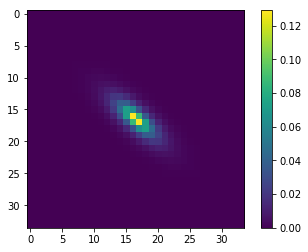

(0.00625, 0.0)


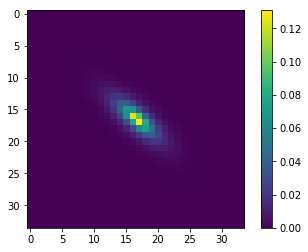

(0.0125, 0.0)


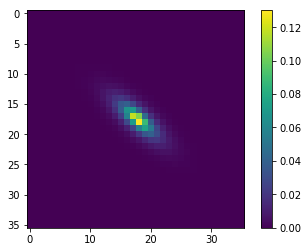

(0.018750000000000003, 0.0)


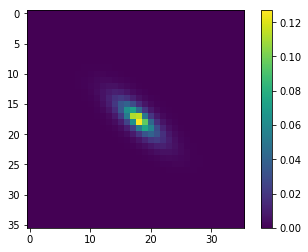

(0.025, 0.0)


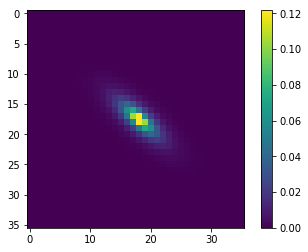

(0.0, 0.00625)


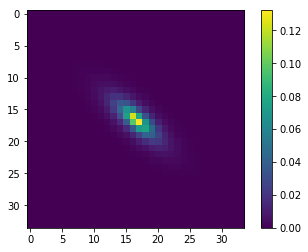

(0.00625, 0.00625)


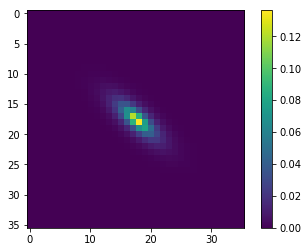

(0.0125, 0.00625)


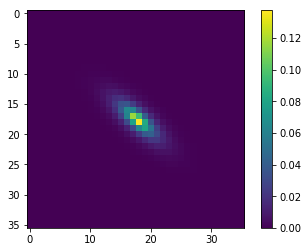

(0.018750000000000003, 0.00625)


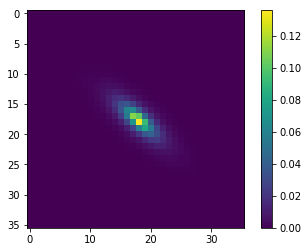

(0.025, 0.00625)


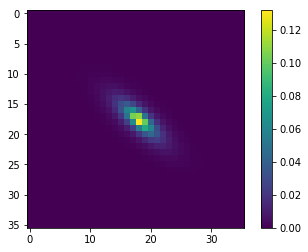

(0.0, 0.0125)


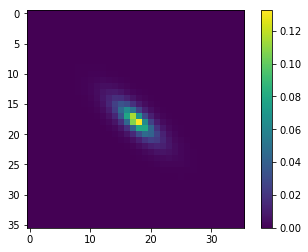

(0.00625, 0.0125)


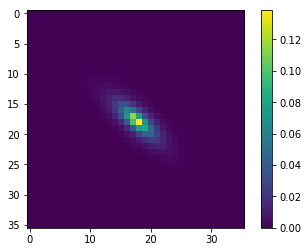

(0.0125, 0.0125)


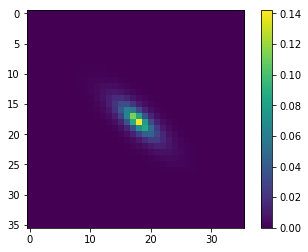

(0.018750000000000003, 0.0125)


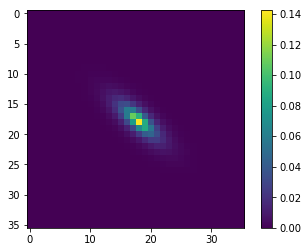

(0.025, 0.0125)


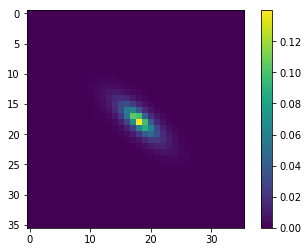

(0.0, 0.018750000000000003)


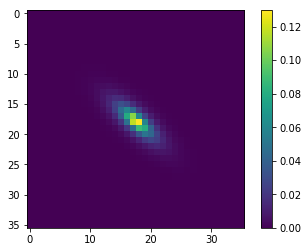

(0.00625, 0.018750000000000003)


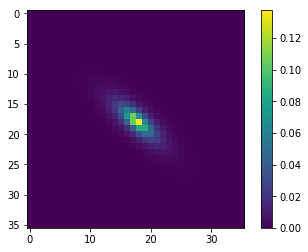

(0.0125, 0.018750000000000003)


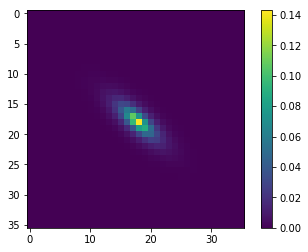

(0.018750000000000003, 0.018750000000000003)


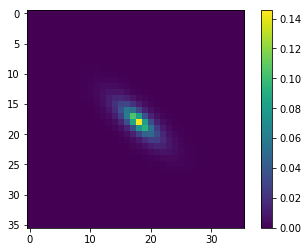

(0.025, 0.018750000000000003)


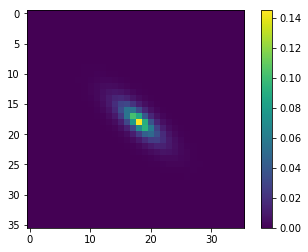

(0.0, 0.025)


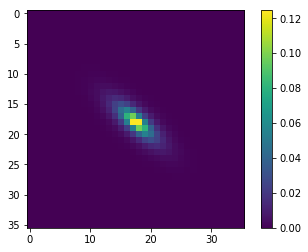

(0.00625, 0.025)


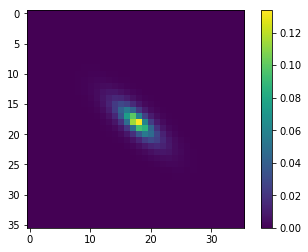

(0.0125, 0.025)


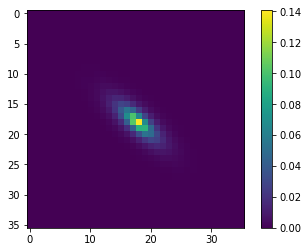

(0.018750000000000003, 0.025)


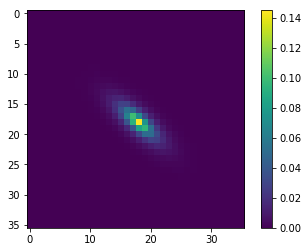

(0.025, 0.025)


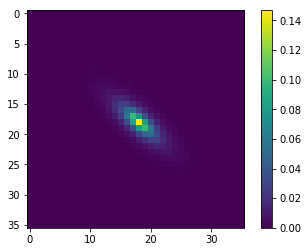

In [21]:
d1shifts = np.linspace(0,ss/2,nx)
aa,bb = np.meshgrid(d1shifts, d1shifts)
d2shifts = zip(aa.flatten(), bb.flatten())
for shift in d2shifts:
    galshift = gals.shift(shift)
    galImShift = galshift.drawImage(scale=ss)
    plt.imshow(galImShift.array)
    plt.colorbar()
    print shift
    plt.show()

In [34]:
fin = galsim.Convolve(gals,psf)
im = fin.drawImage(scale=ss,method='no_pixel')
psfim = psf.drawImage(scale=ss,method='no_pixel')
shape = galsim.hsm.EstimateShear(im,psfim)

In [35]:
shape.psf_shape

galsim.Shear(-1.3338523123892149e-17j)

In [42]:
def galShiftErrs(gal, epsf, nx, ss):
    '''Older version of galShiftErrs with measureShapeBasic hard coded in. See the other function for more documentation'''
    d1shifts = np.linspace(0,ss/2, nx)
    aa, bb = np.meshgrid(d1shifts, d1shifts)
    d2shifts = zip(aa.flatten(), bb.flatten())
    psfIm = epsf.drawImage(scale=ss, method='no_pixel')
    e1arr, e2arr = [],[]
    for shift in d2shifts:
        #psfshift = epsf.shift(shift)
        galshift = gal.shift(shift)
        fin = galsim.Convolve(galshift, epsf)
        galIm = fin.drawImage(scale=ss, method='no_pixel')
        #plt.imshow(galIm.array);plt.colorbar();x1,x2=45,75;plt.xlim(x1,x2);plt.ylim(x1,x2);plt.show()
        #psfIm = psfshift.drawImage(scale=ss, method='no_pixel')
        shape = galsim.hsm.EstimateShear(galIm, psfIm, strict=False)
        if shape.correction_status != 0: 
            e1arr.append(np.nan); e2arr.append(np.nan)
        else:
            e1arr.append(shape.corrected_e1); e2arr.append(shape.corrected_e2)
    print 'Num failures: %d / %d' % (np.sum(np.isnan(e1arr)), len(e1arr))
    #return e1arr, e2arr
    return np.nanmean(e1arr), np.nanmean(e2arr), np.nanstd(e1arr), np.nanstd(e2arr)
 
        
        

In [43]:
airy = galsim.Airy(lam=lamda, diam=diameter, scale_unit=galsim.arcsec, obscuration=0.3, gsparams=gsparams)
pixel = galsim.Pixel(pixel_scale,gsparams=gsparams)
psf = galsim.Convolve(airy, pixel)
given_psf = psf.drawImage(scale=pixel_scale/psf_oversample,method='no_pixel') #Draw oversampled psf image
psf_galsample = psf.drawImage(scale=pixel_scale/gal_oversample,method='no_pixel') #Draw at galaxy scale for shape measurement
psfii = galsim.InterpolatedImage(given_psf, gsparams=gsparams)


In [44]:
nx=5
x=galShiftErrs(gals, psfii, nx, pixel_scale/gal_oversample)

Num failures: 0 / 25


In [27]:
e1arr=x[0]
# e1arr = np.reshape(e1arr,(nx,nx))
# plt.imshow(e1arr)
# plt.colorbar()

In [28]:
galShiftErrs(gals, psfii, nx, pixel_scale/gal_oversample)

Num failures: 0 / 25


(0.08678250223398208,
 0.7430517315864563,
 2.8022651013948336e-06,
 4.758228003391581e-06)

In [185]:
print gals

galsim.Sersic(n=1.0, half_light_radius=0.108705859505, flux=2.16024879771).shear(galsim.Shear(g1=0.05493919119883436,g2=0.46971950650886507))


In [187]:
sh=galsim.shear.Shear(g1=0.05493919119883436,g2=0.46971950650886507)
print sh.e1, sh.e2

0.0897952500379 0.767732098239


In [195]:
print x[0]-sh.e1, x[1]-sh.e2, x[2], x[3]

-0.0030562776720079454 -0.02512964739121004 0.0002165353388151406 0.00019555619987754826


In [190]:
print x[0]-sh.e1, x[1]-sh.e2, x[2], x[3]

-0.0030967775380167095 -0.02544646515167759 2.9881194175008064e-06 4.34890127772154e-06


This pixel error is vastly subdominant to regaussianization error (1e-6 vs 1e-2-1e-3)